# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [119]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, array
from pyspark.sql.types import IntegerType, StringType, BooleanType, DateType, FloatType
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, asc, avg, rank, max, min, mean,first
from pyspark.sql.window import Window
from pyspark import SparkContext, SparkConf

#import Python libraries
import datetime
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

In [120]:
# create a Spark session with configuration
conf = SparkConf().setMaster('local').set('spark.executor.memory','4g').set('sparl.driver.memory','4g')
spark = SparkSession.builder.appName("Sparkify").config(conf=conf).getOrCreate()

# Load and Clean Dataset
Let's load the dataset and clean print out the schema of it 

In [121]:
#Load the dataset and print schema
df = spark.read.json("mini_sparkify_event_data.json")
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [122]:
#df = df0.limit(20000)

Let's drop duplicated rows and rows with invalid userId and sessionId

In [123]:
#We drop dulicated rows 
df = df.dropDuplicates()

#We drop rows with NAN userId and sessionId
df = df.filter(df["userId"] != np.nan)
df = df.filter(df["sessionId"] != np.nan)
df.count()

278154

We then calculate distince users and pages in our analysis

In [124]:
#Number of unique users (by ID)
Num_Unique_Users = df.select('userId').distinct().count()
print("There are {} distinct users (by userID)".format(Num_Unique_Users))

#Number of different type of pages
Num_Unique_Pages = df.select('page').distinct().count()
print("There are {} distinct page types (by userID)".format(Num_Unique_Pages))


There are 225 distinct users (by userID)
There are 19 distinct page types (by userID)


# Exploratory Data Analysis


## Define Churn

We define churned users as user who had been to **Cancellation Confirmation** page. We also define upgrade and downgrade event when users visited **Submit Upgrade** or **Submit Downgrade** page.

In [125]:
#Define churn as user ever been to Cancellation Confirmation page
cancel_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("Cancel", cancel_churn("page"))

#Define downgrade as user ever been to Submit Downgrade page
downgrade_churn = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
df = df.withColumn("Downgrade", downgrade_churn("page"))

#Define upgrade as user ever been to Submit Upgrade page
upgrade_churn = udf(lambda x: 1 if x == "Submit Upgrade" else 0, IntegerType())
df = df.withColumn("Upgrade", upgrade_churn("page"))
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Cancel: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)
 |-- Upgrade: integer (nullable = true)



## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### General Population Exploration
Here we try to analyze all the data recorded

Text(0.5,1,'Distribution of Count of User Activities')

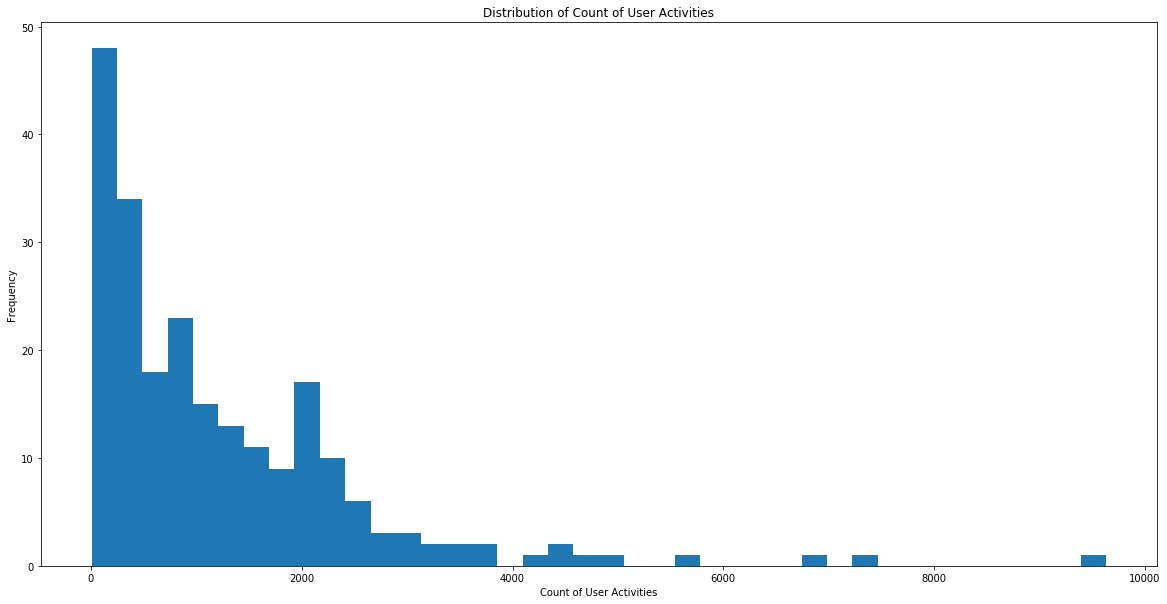

In [126]:
#Plot count of user activities recorded in our dataset
user_count = df.groupBy('userId').count().orderBy("count").toPandas()
plt.figure(figsize = [20,10])
plt.hist(user_count['count'], bins = 40)
plt.xlabel("Count of User Activities")
plt.ylabel("Frequency")
plt.title("Distribution of Count of User Activities")

The distribution of user activity count is apparently right-skewed.

Text(0.5,1,'Number of Page Activities Recorded VS Page Type')

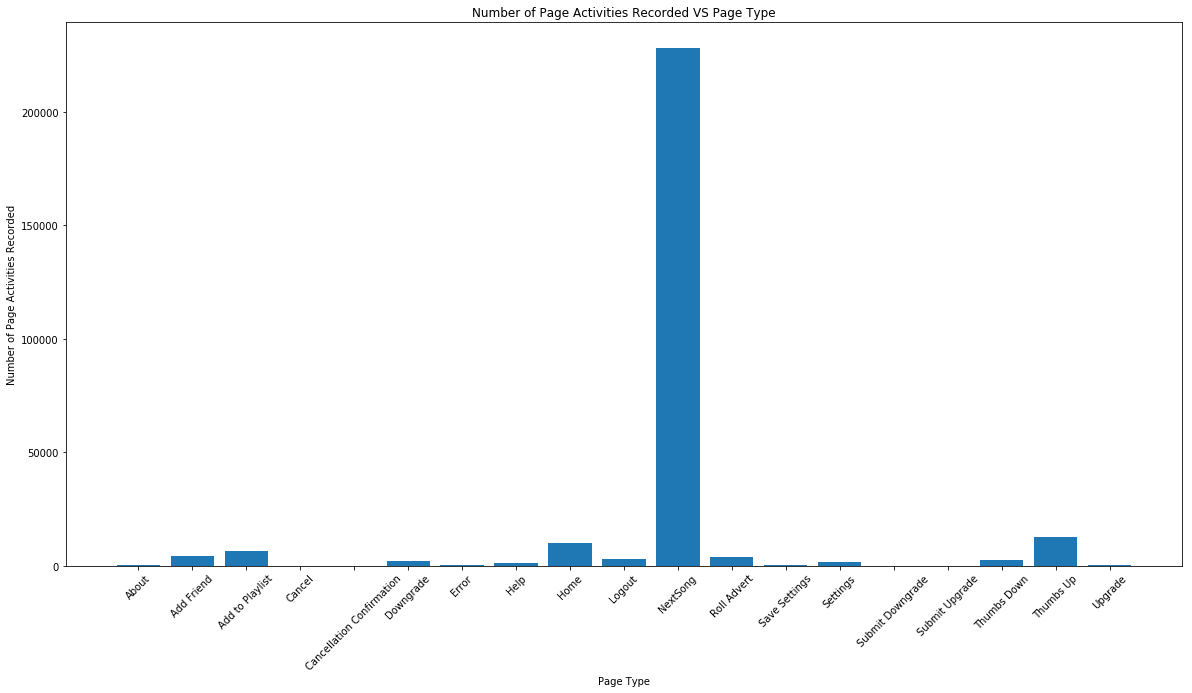

In [127]:
#Plot number of page activities recorded by page type
page_count = df.groupBy('page').count().sort("count", ascending = True).toPandas()
plt.figure(figsize = [20,10])
plt.bar(page_count['page'], page_count['count'])
plt.xticks(rotation = 45)
plt.xlabel("Page Type")
plt.ylabel("Number of Page Activities Recorded")
plt.title("Number of Page Activities Recorded VS Page Type")

The page that has most interactions with users is NextSong

Text(0.5,1,'Number of Users by Gender')

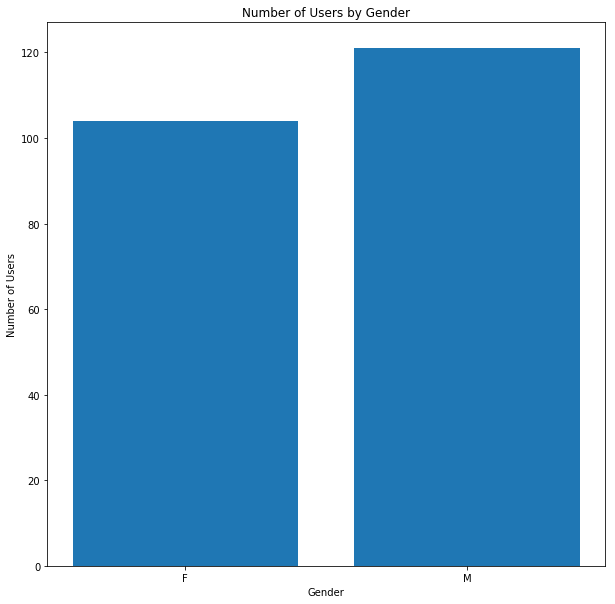

In [128]:
#Plot number of users by gender
gender_count = df.select(['gender','userId']).distinct().groupBy('gender').count().toPandas()
plt.figure(figsize = [10,10])
plt.bar(gender_count['gender'], gender_count['count'])
plt.xlabel("Gender")
plt.ylabel("Number of Users")
plt.title("Number of Users by Gender")

Number of male users is slightly more than female users

Text(0.5,1,'Plot of Number of Users by Locationn')

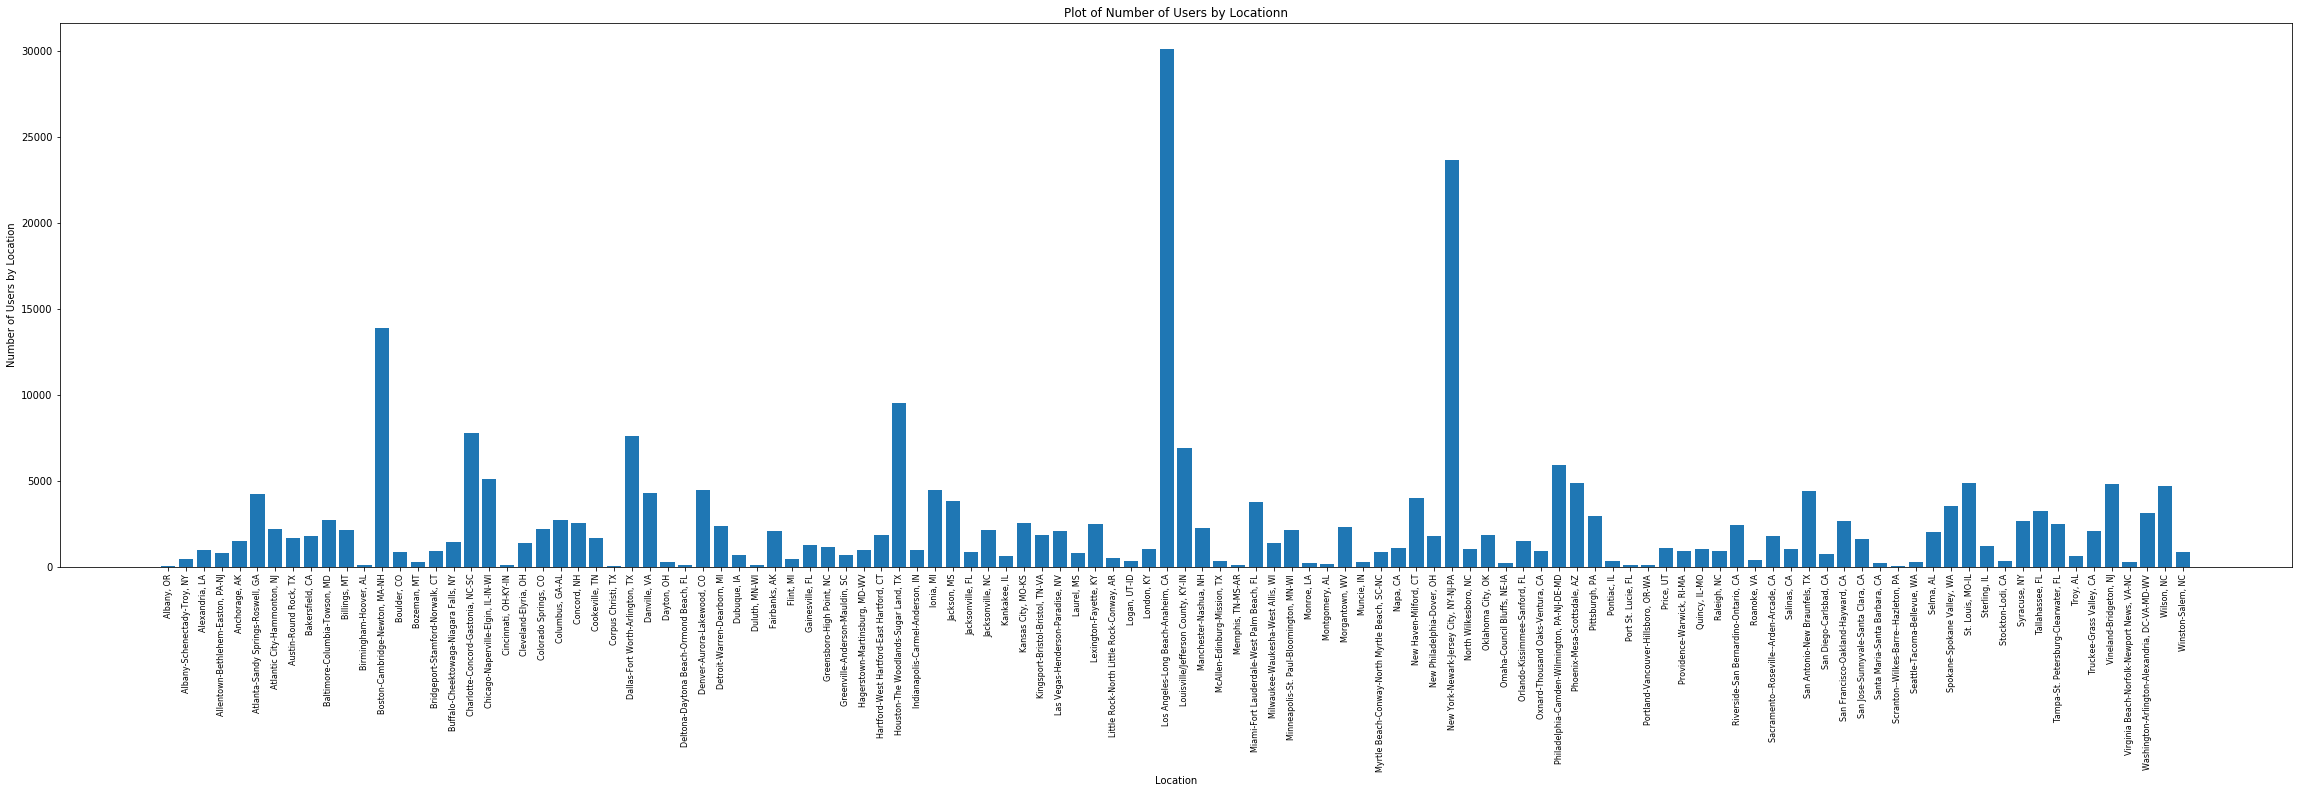

In [129]:
#Plot number of users by location
location_count = df.groupBy('location').count().orderBy("count").toPandas()
plt.figure(figsize = [40,10])
plt.bar(location_count['location'], location_count['count'])
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Location")
plt.ylabel("Number of Users by Location")
plt.title("Plot of Number of Users by Locationn")

#### Most Listened to Artist

Text(0.5,1,'Top 20 Most Listened to Artists')

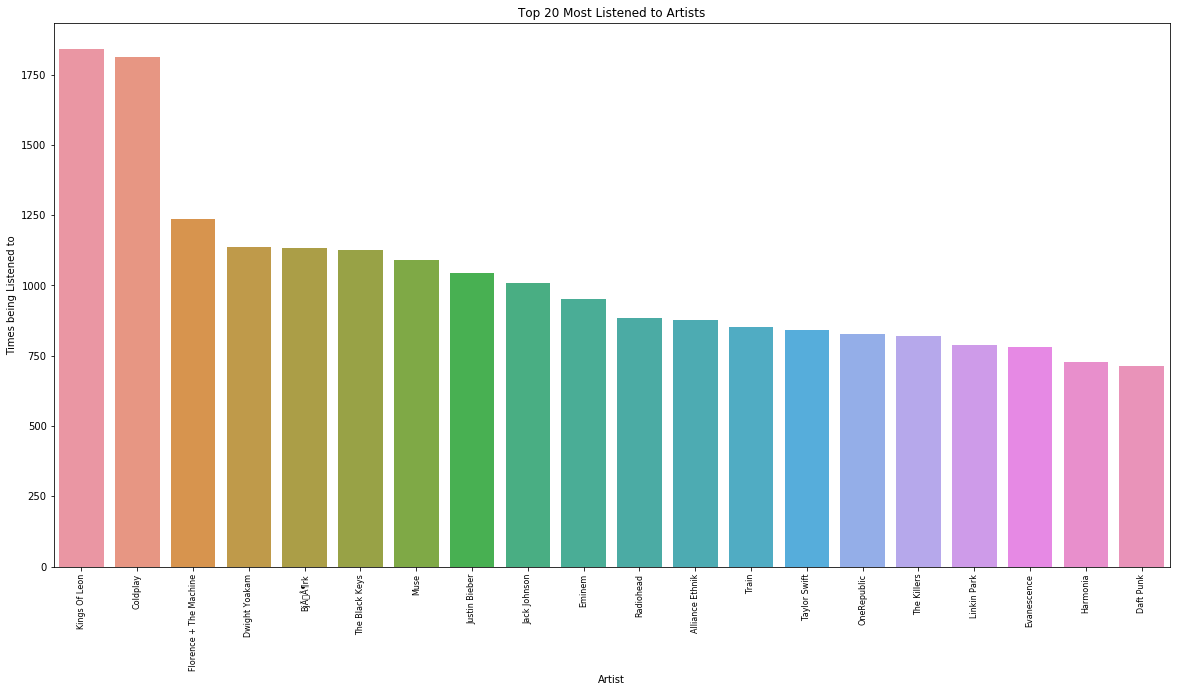

In [130]:
artist = df.groupBy('artist').count().sort('count', ascending = False).toPandas()
artist = artist.dropna()
artist = artist.iloc[:20,:]

plt.figure(figsize = [20,10])
sb.barplot(x = 'artist', y = 'count', data = artist)
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Artist")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Artists")

#### Most Listened to Songs

Text(0.5,1,'Top 20 Most Listened to Songs')

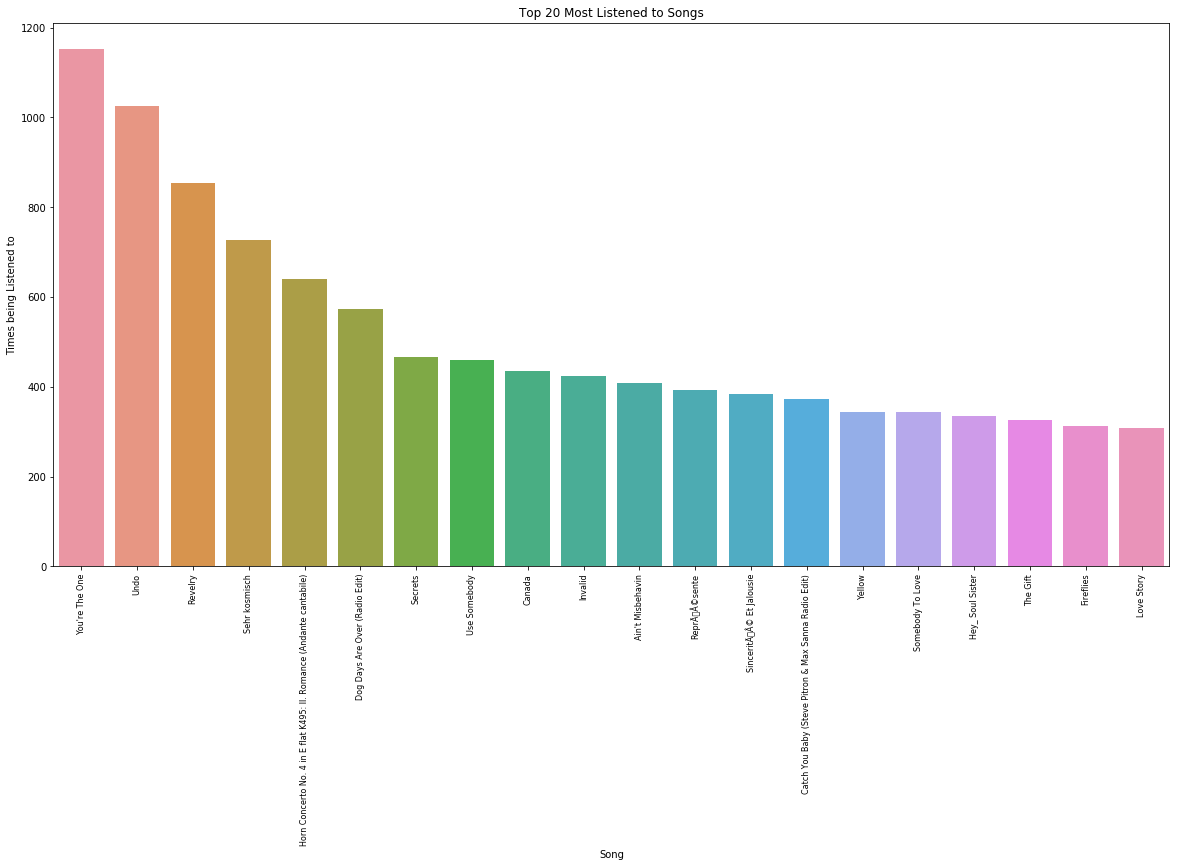

In [131]:
#We groupby songs to filter out most listened to songs
songs = df.groupBy('song').count().sort('count', ascending = False).toPandas()
songs = songs.dropna()
songs = songs.iloc[:20,:]

#We plot the barplot of 20 most listened songs
plt.figure(figsize = [20,10])
sb.barplot(x = 'song', y = 'count', data = songs)
plt.xticks(rotation = 90, fontsize=8)
plt.xlabel("Song")
plt.ylabel("Times being Listened to")
plt.title("Top 20 Most Listened to Songs")

The three cities with most users are Los Angeles, New York and Boston

### Exploration by Churned User
We first do some interesting things

In [132]:
num_churn_user = df.filter(df['Cancel'] == 1).groupBy('userId').count().count()
last_page = df.orderBy(['userId','ts'],ascending = False).groupBy('userId').agg(first('page').alias("last_page"))
last_page_cancel = last_page.filter(last_page['last_page'] == 'Cancellation Confirmation').count()
print("There are {} churned (Cancellation) users, and there are also {} users having their last recorded page in Cancellation confirmation".format(num_churn_user, last_page_cancel))

There are 52 churned (Cancellation) users, and there are also 52 users having their last recorded page in Cancellation confirmation


So that we know that there are 52 churned users and their last visit page were all Cancellation confirmation, and they say good bye to us like forever. Next, we will define users as churned user if they ever submitted cancellation in order to make further analysis.

In [133]:
#Create user table that check if  user has ever churned
churned_users_table = df.groupBy('userId').agg(max('Cancel').alias('Churned'))
churned_users = list(churned_users_table.filter(churned_users_table['Churned'] == 1).select('userId').toPandas()['userId'])

#Define udf to transform user churn state
churn_or_not = udf(lambda x: 1 if x in churned_users else 0, IntegerType())
df = df.withColumn('Churned', churn_or_not('userId'))

#### Times of Downgrade V.S Churned or Not
The next task is to analyze how many times users downgrade by churned users or not. 

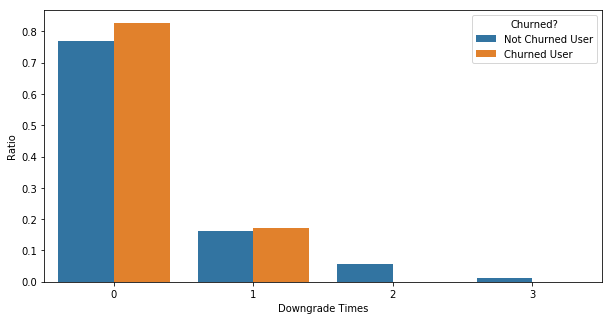

In [134]:
#We first calculate user downgrade time and then the ratio of times per user in that churn group
user_Downgrade_Times = df.groupBy(['userId','Churned']).sum('Downgrade').groupBy(['Churned','sum(Downgrade)']).count().toPandas()
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Downgrade_Times.loc[user_Downgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

#Next, we plot the result using barplot
plt.figure(figsize = [10, 5])
churn_downgrade_bar = sb.barplot(x = 'sum(Downgrade)', y = 'count', data = user_Downgrade_Times, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Downgrade Times')
h, l = churn_downgrade_bar.get_legend_handles_labels() 
churn_downgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')

To our surprise, churned user generally did not downgrade more times than not churned user. In addition, there are some not churned user having even more downgrade experience.

#### Times of Upgrade V.S Churned or Not
The next task is to analyze how many times users upgrade by churned users or not. 

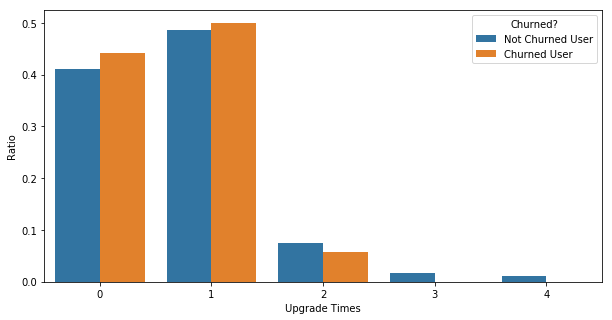

In [135]:
#We first calculate user upgrade times and then the ratio of times per user in that churn group
user_Upgrade_Times = df.groupBy(['userId','Churned']).sum('Upgrade').groupBy(['Churned','sum(Upgrade)']).count().toPandas()
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 1,'count'] /= num_churn_user
user_Upgrade_Times.loc[user_Upgrade_Times['Churned'] == 0,'count'] /= (Num_Unique_Users - num_churn_user)

#Next, we plot the result using barplot
plt.figure(figsize = [10, 5])
churn_Upgrade_bar = sb.barplot(x = 'sum(Upgrade)', y = 'count', data = user_Upgrade_Times, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Upgrade Times')
h, l = churn_Upgrade_bar.get_legend_handles_labels() 
churn_Upgrade_bar.legend(h, ['Not Churned User', 'Churned User'], title='Churned?', loc = 'upper right')

The ratio of upgrade times seems to be quite similar between churned and non churned user. However, it's interesting that some non churned users upgrade up to 4 times within the time span.

#### Final Level When They Churned
In this cell, we try to figure out the final level when users decide to cancel the service

Text(0.5,0,'Count')

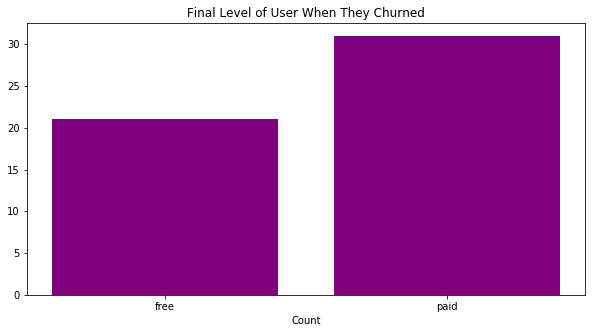

In [136]:
final_level_churn = df.filter(df['Cancel'] == 1).groupBy('level').count().toPandas()

plt.figure(figsize = [10, 5])
plt.bar(final_level_churn['level'], final_level_churn['count'], color='purple')
plt.title('Final Level of User When They Churned')
plt.xlabel('Count')

Slightly more users were in paid level when they decided to churn, that is, cancel the whole service

#### Average Session Length Analysis

The mean value of average session length for churned user groups are:
Churned Users: 15788.142997099727
Non-Churned Users: 18169.869242887227


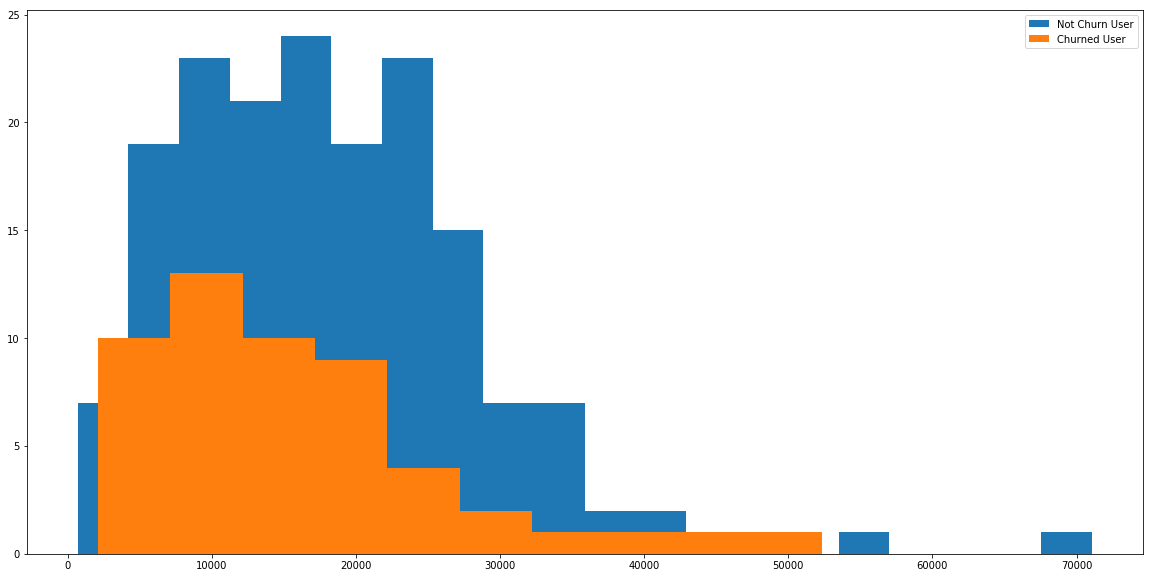

In [137]:
avg_session_length_user = df.groupBy(['userId','Churned',"sessionId"]).sum('length').groupBy(['userId','Churned']).agg(avg('sum(length)').alias('Average Session Length')).toPandas()

plt.figure(figsize = [20,10])
(n, bins, patches)  = plt.hist(avg_session_length_user[avg_session_length_user['Churned'] == 0]['Average Session Length'], bins = 20)
plt.hist(avg_session_length_user[avg_session_length_user['Churned'] == 1]['Average Session Length'])
plt.legend(['Not Churn User','Churned User'])

session_length_nonchurn = avg_session_length_user[avg_session_length_user['Churned'] == 0]['Average Session Length'].mean()
session_length_churn = avg_session_length_user[avg_session_length_user['Churned'] == 1]['Average Session Length'].mean()
print("The mean value of average session length for churned user groups are:\nChurned Users: {}\nNon-Churned Users: {}".format(session_length_churn,session_length_nonchurn))

From the distribution of average session length, we can observe that the mean of non churned users are greater than churned users with some extreme values over 60000.

#### Churn Gender Analysis

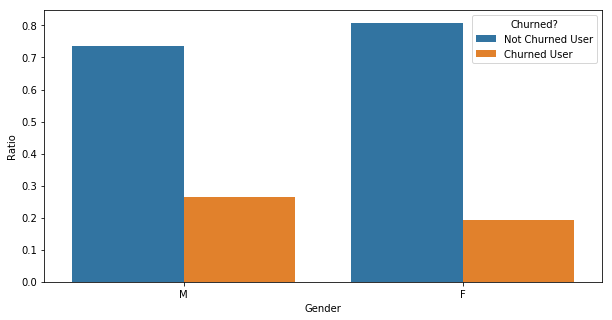

In [138]:
#We create gender churn statistic by groupBy method
gender_churn = df.groupBy(['userID','gender']).agg(max('Cancel').alias("Churned")).groupBy(['gender','Churned']).count().toPandas()

#Calculate number of male and female users
num_female = gender_churn[gender_churn['gender'] == 'F']['count'].sum()
num_male = gender_churn[gender_churn['gender'] == 'M']['count'].sum()

#Transform counts to ratio
gender_churn.loc[gender_churn['gender'] == 'F', 'count'] /= num_female
gender_churn.loc[gender_churn['gender'] == 'M', 'count'] /= num_male
gender_churn.columns = ['gender', 'Churned', 'ratio']

#Plot results using barplot with hue Churned
plt.figure(figsize = [10, 5])
gender_churn_bar = sb.barplot(x = 'gender', y = 'ratio', data = gender_churn, hue = 'Churned')
plt.ylabel('Ratio')
plt.xlabel('Gender')
h, l = gender_churn_bar.get_legend_handles_labels() 
gender_churn_bar.legend(h, ['Not Churned User', 'Churned User'], title = 'Churned?', loc = 'upper right')

It seems slightly higher proportion of female users are churned compared to male users.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### Calculate Time Span of User
Because we will feature the data in a daily average basis, we first have to create the time span of each user with earliest and latest interaction recorded

In [139]:
#Define window for time span calculation
windowSpec  = Window.partitionBy("userId")

#Define udf for creating new column
def time_length(col1, col2):
    """
    This function returns the difference in time, that is, time span
    
    Input: Start and end timestamp
    Output: Difference between start and end timestamp in days
    """
    time_gap = col1 - col2
    return time_gap/86400000

time_delta = udf(time_length, FloatType())

#Create new column containing time span in days
df = df.withColumn("Time-Max", max(col('ts')).over(windowSpec))
df = df.withColumn("Time-min", min(col('ts')).over(windowSpec))
df = df.withColumn("Time-Span", time_delta('Time-Max',"Time-min"))
df = df.drop('Time-Max','Time-min')

### Create userId-Churned DataFrame
This dataframe will become our seed dataframe, we will use this dataframe to merge with other results later

In [140]:
User_Feature_Dataframe = df.groupBy('userId').agg(max('Cancel').alias('Churned'))

In [141]:
User_Feature_Dataframe.printSchema()

root
 |-- userId: string (nullable = true)
 |-- Churned: integer (nullable = true)



### Create userId-Time Span DataFrame
This dataframe will become our seed dataframe, we will use this dataframe to merge with other results later

In [142]:
User_day = df.groupBy(['userId','Time-Span']).count().drop('count')
User_Feature_Dataframe = User_Feature_Dataframe.join(User_day, on='userId', how = 'left')

### Average Session Length
The first feature is average session length. We groupby the session and sum over each session to get total length for each session, and then followed by dividing the total number of session of that userId to get average session length length of that user

In [143]:
avg_session_length_user = df.groupBy(['userId',"sessionId"]).sum('length').groupBy('userId').agg(avg('sum(length)').alias('Average Session Length'))
User_Feature_Dataframe = User_Feature_Dataframe.join(avg_session_length_user, on='userId', how = 'left')

### Total Songs 

In [144]:
all_songs = df.filter(df['artist'].isNotNull()).groupBy('userId').agg(count('artist').alias('Total Songs'))
User_Feature_Dataframe = User_Feature_Dataframe.join(all_songs, on='userId', how = 'left')

### Gender

In [145]:
gender = df.groupBy('userId').agg(first('gender').alias("Gender"))
User_Feature_Dataframe = User_Feature_Dataframe.join(gender, on='userId', how = 'left')

### Total Time Spent


In [146]:
user_time = df.groupBy('userId').agg(Fsum('length').alias('Total Time Spent'))
User_Feature_Dataframe = User_Feature_Dataframe.join(user_time, on='userId', how = 'left')

### Total Sessions and Item per Session

In [147]:
sessions = df.groupBy(['userId','sessionId']).count()
avg_item_session = sessions.groupBy('userId').agg(avg('count').alias('Average Session Item'))
total_session = sessions.groupBy('userId').agg(count('sessionId').alias('Total Sessions'))
User_Feature_Dataframe = User_Feature_Dataframe.join(avg_item_session, on='userId', how = 'left')
User_Feature_Dataframe = User_Feature_Dataframe.join(total_session, on='userId', how = 'left')

### Most visit page other than NextSong
We are also curious about which page 

In [148]:
#Second_Most_Visit_Page = df.filter(df['page']!='NextSong').groupBy(['userId','page']).count().orderBy(['userId','count'], ascending=False).groupBy('userId').agg(first('page').alias("Second Most Visit Page"))
#Distinct_2nd_Page = Second_Most_Visit_Page.select('Second Most Visit Page').distinct().collect()
#User_Feature_Dataframe = User_Feature_Dataframe.join(Second_Most_Visit_Page, on='userId', how = 'left')

### Final Level

In [149]:
final_state = df.orderBy(['userId','ts'],ascending=False).groupBy('userId').agg(first('level').alias('Final Level'))
User_Feature_Dataframe = User_Feature_Dataframe.join(final_state, on='userId', how = 'left')

### Average Thumbs Up and Down Per Song
In this cell, we calculate the total thumbs up and down of each user, and also we create a new feature to get the proportion of thumbs up.

In [150]:
#We create thumbs dataframe containing only page of our interest, that is "Thumbs Up" and "Thumbs Down"
thumbs = df.filter((df['page'] == "Thumbs Up")|(df['page'] == "Thumbs Down"))

#Then, we use aggregation groupBy function to get number of thumbs up and down
thumbs_all = thumbs.filter(thumbs['page']=="Thumbs Up").groupBy('userId').agg(count('page').alias('Thumbs Up Count'))
thumbs_down = thumbs.filter(thumbs['page']=="Thumbs Down").groupBy('userId').agg(count('page').alias('Thumbs Down Count'))
thumbs_all = thumbs_all.join(thumbs_down, on = 'userId', how = 'left').na.fill(0)

#Define function for proportion computation
def thumbup_ratio(col1, col2):
    """
    This function calculates the proport of col1 among col1 and col2
    
    Input: Column element of interest
    Output: Proportion of col1 among col1 and col2
    """
    return col1/(col1+col2)
ratio = udf(thumbup_ratio, FloatType())

#Create new column that shows the thumbs up ratio
thumbs_all = thumbs_all.withColumn('Thumbs Up Ratio', ratio('Thumbs Up Count','Thumbs Down Count'))
thumbs_songs = all_songs.join(thumbs_all, on = 'userId', how = 'left').fillna(0)
thumbs_songs = thumbs_songs.withColumn('Thumbs Up per Song', thumbs_songs['Thumbs Up Count'] / thumbs_songs['Total Songs'])
thumbs_songs = thumbs_songs.withColumn('Thumbs Down per Song', thumbs_songs['Thumbs Down Count'] / thumbs_songs['Total Songs'])
thumbs_songs = thumbs_songs.drop('Thumbs Up Count', 'Thumbs Down Count', 'Total Songs')
User_Feature_Dataframe = User_Feature_Dataframe.join(thumbs_songs, on='userId', how = 'left')

### Upgrade and downgrade times
We add feature by calculating the total times of upgrade and downgrade of users

In [151]:
user_upgrade_downgrade = df.groupBy('userId').agg(Fsum('Upgrade').alias('Times of Upgrade'),Fsum('Downgrade').alias('Times of Downgrade'))
User_Feature_Dataframe = User_Feature_Dataframe.join(user_upgrade_downgrade, on='userId', how = 'left')

#### Total Add Friends

In [152]:
Total_Friends = df.filter(df['page'] == 'Add Friend').groupBy('userId').agg(count('page').alias('Total Friends'))
User_Feature_Dataframe = User_Feature_Dataframe.join(Total_Friends, on='userId', how = 'left')

###  Duration since Registration

In [153]:
Time_Table = df.groupBy('userId').agg(max('registration').alias('Registration_Time'),max('ts').alias('Latest_Time'))


time_delta = udf(time_length, FloatType())

#Create new column containing time span in days
Time_Table = Time_Table.withColumn("Registration_Durartion", (Time_Table['Latest_Time'] - Time_Table['Registration_Time'])/86400000/30)
Time_Table = Time_Table.drop('Registration_Time', 'Latest_Time')
User_Feature_Dataframe = User_Feature_Dataframe.join(Time_Table, on='userId', how = 'left')

### Roll Advert over Total Songs 

In [154]:
roll_advert = df.filter(df['page'] == 'Roll Advert').groupBy('userId').agg(count('page').alias('Roll Advert Times'))
roll_advert_songs = all_songs.join(roll_advert, on = 'userId', how = 'left').fillna(0)
roll_advert_songs = roll_advert_songs.withColumn('Roll_Advert_over_Songs', roll_advert_songs['Roll Advert Times'] / roll_advert_songs['Total Songs'])
roll_advert_songs = roll_advert_songs.drop('Roll Advert Times', 'Total Songs')
User_Feature_Dataframe = User_Feature_Dataframe.join(roll_advert_songs, on = 'userId', how = 'left')

In [155]:
User_Feature_Dataframe = User_Feature_Dataframe.fillna(0)

In [156]:
def transform(col):
    global category
    if col == category:
        return 1
    else:       
        return 0

def makedummy(df, col):
    categories = df.select(col).distinct().collect()
    for cat in categories:
        global category
        category = cat[col]        
        udfs = udf(transform, IntegerType())
        df = df.withColumn(col + '_' + str(category), udfs(col))
    return df
        
    
User_Feature_Dataframe = makedummy(User_Feature_Dataframe,'Final Level')
User_Feature_Dataframe = makedummy(User_Feature_Dataframe,'Gender')
    

In [157]:
average_columns = ['Total Songs','Total Time Spent','Total Sessions']
for cols in average_columns:
    title = '_'.join('Total Spent'.split()[1:])
    User_Feature_Dataframe = User_Feature_Dataframe.withColumn(title + '_per_Day', User_Feature_Dataframe[cols]/User_Feature_Dataframe['Time-Span'])
    User_Feature_Dataframe = User_Feature_Dataframe.drop(cols)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [39]:
#Import Pyspark machine learning library
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Normalizer, PCA, StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [44]:
User_Feature_Dataframe.columns

['Churned',
 'Time-Span',
 'Average Session Length',
 'Total Songs',
 'Total Time Spent',
 'Average Session Item',
 'Total Sessions',
 'Thumbs Up Count',
 'Thumbs Down Count',
 'Thumbs Up Ratio',
 'Times of Upgrade',
 'Times of Downgrade',
 'Total Friends',
 'Registration_Durartion',
 'Roll_Advert_over_Songs',
 'Final Level_free',
 'Final Level_paid',
 'Gender_F',
 'Gender_M']

In [46]:
A = User_Feature_Dataframe.columns
A.remove('Churned')
A

['Time-Span',
 'Average Session Length',
 'Total Songs',
 'Total Time Spent',
 'Average Session Item',
 'Total Sessions',
 'Thumbs Up Count',
 'Thumbs Down Count',
 'Thumbs Up Ratio',
 'Times of Upgrade',
 'Times of Downgrade',
 'Total Friends',
 'Registration_Durartion',
 'Roll_Advert_over_Songs',
 'Final Level_free',
 'Final Level_paid',
 'Gender_F',
 'Gender_M']

In [47]:
feature_columns = User_Feature_Dataframe.columns
feature_columns.remove('Churned')
assembler = VectorAssembler(inputCols = feature_columns, outputCol = "Churned")
ml_table = assembler.transform(User_Feature_Dataframe)

IllegalArgumentException: 'Output column Churned already exists.'

In [48]:
scaler = Normalizer(inputCol="NumFeatures", outputCol="ScaledNumFeatures")
norm = scaler.transform(User_Feature_Dataframe)

TypeError: __init__() got an unexpected keyword argument 'inputCols'

In [ ]:
scaler2 = StandardScaler(inputCol="NumFeatures", outputCol="ScaledNumFeatures2", withStd=True)
scalerModel = scaler2.fit(df)
df = scalerModel.transform(df)

In [ ]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)

In [ ]:
lrModel = lr.fit(data)

In [ ]:
lr = LinearRegression(maxIter=5, regParam=0.0, fitIntercept=False, solver="normal")

In [ ]:
regexTokenizer = RegexTokenizer(inputCol="Body", outputCol="words", pattern="\\W")
cv = CountVectorizer(inputCol="words", outputCol="TF", vocabSize=10000)
idf = IDF(inputCol="TF", outputCol="features")
indexer = StringIndexer(inputCol="oneTag", outputCol="label")

lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)

pipeline = Pipeline(stages=[regexTokenizer, cv, idf, indexer, lr])


In [ ]:
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

In [34]:
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)

278154

In [36]:
prediction = cvModel.transform(test)
selected = prediction.select("id", "text", "probability", "prediction")

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Cancel: integer (nullable = true)
 |-- Downgrade: integer (nullable = true)



Text(0.5,1,'Times of downgrade distribution of users')

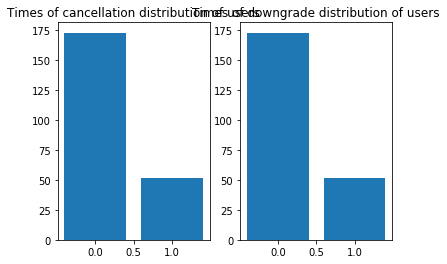

In [37]:
user_Cancel_Downgrade_Times = df0.groupBy('userId').sum('Cancel','Downgrade')
#user_Cancel_Times = user_Cancel_Downgrade_Times.groupBy('sum(Cancel)').count().toPandas()
#user_Downgrade_Times = user_Cancel_Downgrade_Times.groupBy('sum(Downgrade)').count().toPandas()

#plt.subplot(1,3,1)
#plt.bar(user_Cancel_Times['sum(Cancel)'], user_Cancel_Times['count'])
plt.title('Times of cancellation distribution of users')
plt.subplot(1,3,3)
plt.bar(user_Downgrade_Times['sum(Downgrade)'], user_Downgrade_Times['count'])
plt.title('Times of downgrade distribution of users')

([<matplotlib.axis.XTick at 0x7f7e401c4dd8>,
 <a list of 2 Text xticklabel objects>)

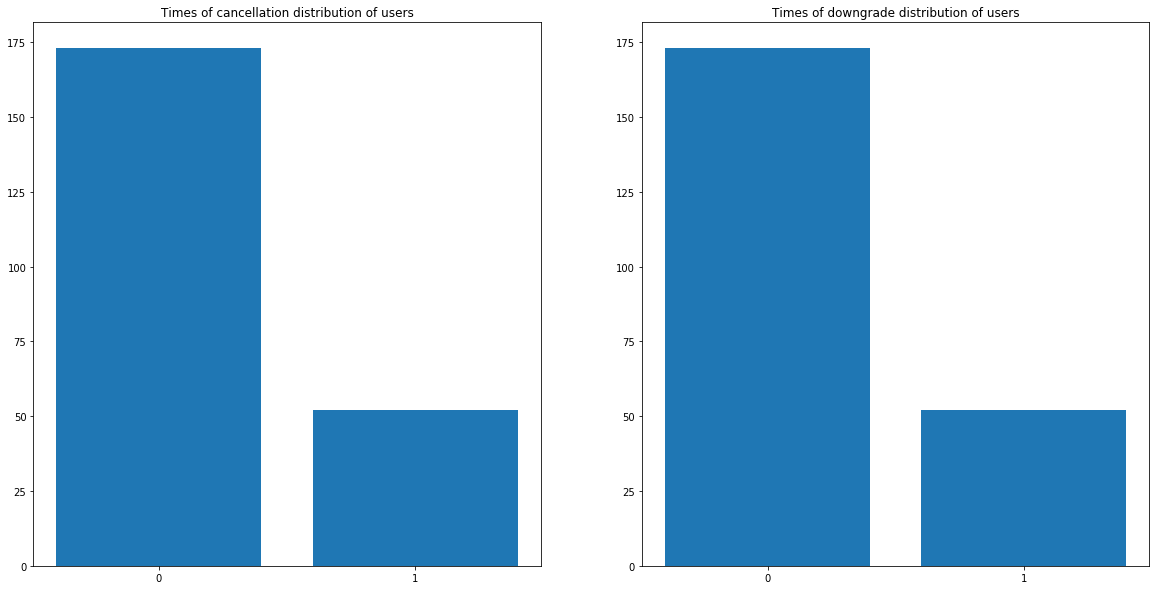

In [42]:
plt.figure(figsize=[20,10])
plt.subplot(1,2,1)
plt.bar(user_Cancel_Times['sum(Cancel)'], user_Cancel_Times['count'])
plt.title('Times of cancellation distribution of users')
plt.xticks(user_Cancel_Times['sum(Cancel)'])
plt.subplot(1,2,2)
plt.bar(user_Downgrade_Times['sum(Downgrade)'], user_Downgrade_Times['count'])
plt.title('Times of downgrade distribution of users')
plt.xticks(user_Cancel_Times['sum(Cancel)'])

In [96]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Time-Span: float (nullable = true)



# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [12]:
#We drop dulicated rows 
df0 = df0.dropDuplicates()

#We drop rows with NAN userId and sessionId
df0 = df0.filter(df["userId"] != np.nan)
df0 = df0.filter(df["sessionId"] != np.nan)
df0.count()

278154

In [82]:
user_log_valid = df.withColumn("phase", Fsum("Cancel").over(windowval))

In [121]:
df0.filter((df['userId']==140)&(df['page']=='Submit Downgrade')).show()

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+------+---------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|Cancel|Downgrade|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+------+---------+
|  null|Logged In|   Lucero|     F|          163|    Reed|  null| paid|Louisville/Jeffer...|   PUT|Submit Downgrade|1536642109000|     1643|null|   307|1541523845000|"Mozilla/5.0 (Win...|   140|     0|        0|
|  null|Logged In|   Lucero|     F|           19|    Reed|  null| paid|Louisville/Jeffer...|   PUT|Submit Downgrade|1536642109000|      753|null|   307|

In [117]:
user_Cancel_Downgrade_Times = df0.groupBy('userId').sum('Cancel','Downgrade')

In [86]:
#timestamp
adjust_timestamp = udf(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime("%Y-%m-%d %H:%M"), DateType())
df = df.withColumn("Time", adjust_timestamp('ts'))


datetime.datetime(2021, 3, 15, 8, 1, 22, 472074)

In [119]:
user_Cancel_Downgrade_Times.sort('sum(Downgrade)',ascending=False).show()

+------+-----------+--------------+
|userId|sum(Cancel)|sum(Downgrade)|
+------+-----------+--------------+
|100007|          1|             1|
|300007|          1|             1|
|    17|          1|             1|
|    28|          1|             1|
|100025|          1|             1|
|    18|          1|             1|
|100005|          1|             1|
|    87|          1|             1|
|     3|          1|             1|
|100022|          1|             1|
|100014|          1|             1|
|   125|          1|             1|
|100006|          1|             1|
|   101|          1|             1|
|    70|          1|             1|
|    54|          1|             1|
|    73|          1|             1|
|100021|          1|             1|
|    29|          1|             1|
|    51|          1|             1|
+------+-----------+--------------+
only showing top 20 rows



In [27]:
df0.select(['userId','page']).filter(df0['page']=='Cancellation Confirmation').groupBy('userId').agg(count('page').alias('Count')).sort('Count',ascending=False).show(n=230)

+------+-----+
|userId|Count|
+------+-----+
|   125|    1|
|    51|    1|
|    54|    1|
|100014|    1|
|   101|    1|
|100021|    1|
|    29|    1|
|    73|    1|
|    87|    1|
|     3|    1|
|    28|    1|
|100022|    1|
|100025|    1|
|300007|    1|
|100006|    1|
|    18|    1|
|    70|    1|
|100005|    1|
|    17|    1|
|100007|    1|
|300001|    1|
|100009|    1|
|100015|    1|
|200024|    1|
|100003|    1|
|   103|    1|
|100024|    1|
|    53|    1|
|   122|    1|
|200017|    1|
|    58|    1|
|100011|    1|
|100019|    1|
|100012|    1|
|200018|    1|
|200016|    1|
|200020|    1|
|   106|    1|
|   143|    1|
|    32|    1|
|200001|    1|
|   105|    1|
|200011|    1|
|100023|    1|
|100013|    1|
|100017|    1|
|   121|    1|
|    12|    1|
|200015|    1|
|   129|    1|
|200021|    1|
|100001|    1|
+------+-----+



In [21]:
df0.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

